In [1]:
#!pip install emoji
#!pip install fasttext
#!pip install transformers
#!pip install transformers
#https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
#!pip install transformers

%pip install fasttext livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 1.3 MB/s eta 0:00:01
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
     |████████████████████████████████| 1.6 MB 14.8 MB/s eta 0:00:01
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3164953 sha256=5dd6a200cc0a32e8dd5003c7f91817931e206797c9f6b0e62f08de326c8f2630
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [2]:
import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import re

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn
from nltk import word_tokenize,pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path

from livelossplot.inputs.tf_keras import PlotLossesCallback

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import pickle
import itertools
import fasttext.util

from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 424638981490150960
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7966654917838527249
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [3]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12631354483412937460
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16139419648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11938701560225483689
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

# Set Parameters

In [5]:
TRAIN_MODE= True
emb_dim=50
batchsize=256

sequence_size= 500
READ_DATA = True
TRAIN_WORD_SENTIMENT = True
ETL_STOPWORDS= True
FIT_MODEL = True
FIT_ATTENTION_MODEL = True
FIT_TRANSFORMER_MODEL = True
ETL_SENTENCE_SIZE = True
MAKE_PREDICTION = True

TUNNING = True
TUNNING_ATTENTION_V2 = True
TUNNING_ATTENTION = True
TUNNING_TRANSFORMER = True

max_trials = 30
threshold = 1
classN=1
tf.random.set_seed(0)
np.random.seed(0)

In [6]:

Emoji_Dict ={
    ":p" : "<>" ,
    ":)" :"<SMILE_SIMPLE>",
    ":(":"<SAD>",
    ":'(":"<CRY>",
    ":')":"<BLINK_EYE>",
    ":d" : "<BIG_SMILE>", 
    ":-)":"<SMILE_HAPPY>",
    ";-)":"<SMILE_A_LOT>",
    ":<})":"<MOUSTACHE_SMILE>",
    ":-||":"<MAD>",
    ":-(":"<SAD>", 
    ":'-(":"<CRY>",
    ":-))":"<HAPPY>",
    ":-*": "<KISS>",
    ":-P~":"<LICK>", 
    ":-o" :"<SURPRISED>",
    ":-|":"<GRIM>",
    ":-/":"<PERPLEXED>",
    "=:O"  :"<FRIGHTNED>",
    "<3": "<LOVE>",
    "*****": "<5_STARS>",
    "****": "<4_STARS>",
    "***": "<3_STARS>",
    "**": "<2_STARS>",
    "*": "<1_STARS>",
    ".org" : "<>"
    }

SPECIAL_NUMBERS = {
    "1" : "<1_STARS>",
    "2": "<2_STARS>",
    "3": "<3_STARS>",
    "4": "<4_STARS>", 
    "5": "<5_STARS>"
}

# Set Functions to perform data cleaning and feature engineering

In [7]:

def translate_sentiment(sentiment, op=4):
    if op ==4:
        if sentiment >0 and sentiment <=3 :
            sentiment = 0
        elif sentiment >3 and sentiment < 5 :
            sentiment = 1
        elif sentiment >=5 and sentiment <=8 :
            sentiment = 2
        elif sentiment >8 and sentiment <=10 :
            sentiment = 3
    else:
        if sentiment <5 :
            sentiment = 0
        elif sentiment >=5:
            sentiment = 1
        
    return sentiment

from string import digits


def process_dataset(review_list):
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['N'] = wn.NOUN
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    
    string_check= re.compile('[^0-9a-zA-Z.?!\'<>]')
    
    processed_review = []
    for index, review in enumerate(review_list):

        if index %5000 == 0:
            print("Process process : ",index,"/",len(review_list)," sentences processed...")

        original = review
    
        if review.find(".org") != -1:
            site = review.split(".org")[0].split()[-1]
            review = review.replace(site+".org","<URL>")
        elif review.find(".com") != -1:
            site = review.split(".com")[0].split()[-1]
            review = review.replace(site+".com","<URL>")
        
        line = (re.sub('\.+', " . ", review).replace("?"," . ").replace("!"," . ").replace("<br />"," "))


        for em in list(Emoji_Dict.keys()):
            line = line.replace(em,Emoji_Dict[em])

        stripped =[]
        tmp = nltk.word_tokenize(line)
        for w in tmp:
            if  w.isdigit() and str(w) in list(SPECIAL_NUMBERS.keys()):
                stripped.append(SPECIAL_NUMBERS[w])
            elif  w.isdigit():
                stripped.append("<NUMBER>")
            else:
                stripped.append(w)

        line = ' '.join(stripped)
        line = re.sub(string_check, ' ', (line)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace("'nt"," not")
                        .replace("i'm","i am")
                        .replace("i 'm","i am")
                        .replace("'s"," ")
                        .replace("don't","do not")
                        .replace("can't","can not")
                        .replace("n't"," not")
                        .replace("'re"," are")
                        .replace("'d"," would")
                        .replace("'ve"," have")
                        .replace("'ll"," will")
                        .replace("'till"," until")
                        )
            
        
        tokens = word_tokenize(line)
        lemmas = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]

        line = " ".join(lemmas).replace(" >",">").replace("< ","<")

        processed_review.append(line)
            
    return  processed_review

    
def read_dataset(folder):
    
    review_list = []
    sentiment_list = []
    index_list = []

    for i , path in enumerate(Path(folder).rglob('*.txt')):

        if i %5000 == 0:
            print(i,"files read...")
            
        info = ((str(path).split('\\')[-1]).split('.')[0]).split('_')
        
        try:
            if info[0] != '' and info[1] != '':
                identifier, sentiment = int(info[0]), int(info[1])
            else:
                print("invalid path format : ",path)

            f=open(path,'r', encoding="utf8")

            original = str(f.read().lower())
            original = ' '.join(original.split('\t'))

            sentiment = translate_sentiment(sentiment, op = classN)

            review_list.append(original)
            sentiment_list.append(sentiment)
            index_list.append(i)
            
            if i < 1 :
                print("Original --->",original)
    
            f.close()


        except Exception as e : 
            print("invalid path format : ",path, ".", e)


    cols = ['review','sentiment', 'id']
    df_tmp= pd.DataFrame(columns=cols)

    print(len(review_list), len(sentiment_list), len(index_list))
    df_tmp["review"] = review_list
    df_tmp["sentiment"] =sentiment_list
    df_tmp["id"] =index_list

    return  df_tmp


In [8]:
def remove_stop_words( sentence,stop_words,ds_size, index): #https://stackoverflow.com/questions/45447848/check-for-words-from-list-and-remove-those-words-in-pandas-dataframe-column

    try:
        word_tokens = sentence.values[0].split()
    except:
        word_tokens = sentence.split()

    if index % 5000 == 0:
        print(ds_size,"\ ",index)
    
    sent_df = pd.DataFrame(word_tokens, columns=["words"])
    
    return ' '.join(sent_df[~sent_df.words.isin(stop_words)].words.tolist())

def get_max_sentence_size(seq):
    maxWords=0
    
    for seq_x in seq:
        if(maxWords<len(seq_x)):
            maxWords = len(seq_x)
    return maxWords

def tokenize_data(tookizer_aux, df_aux):

    if TRAIN_MODE == True :
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.iloc[:, 0].tolist()) # All the corpus text integer index
    else:
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.review)
        
    word_index = tookizer_aux.word_index
    vocab_len = len(word_index) + 1  
    
    return tookizer_aux, vocab_len,sequences_aux,word_index

def check_word_frequency(tokenizer_temp):
    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer_temp.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency

def check_sentece_size(df_aux,size_ = None):
    
    for i in range(0, len(df_aux.review.values)):
        
        if  size_ is not None and len(df_aux.at[i,"review"].split()) > size_:
            df_aux.at[i,"sentence_size"] = -1
        else:
            df_aux.at[i,"sentence_size"] = len(df_aux.at[i,"review"].split())
        
    return df_aux

def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


def plot_words(d):
    fig, ax = plt.subplots(figsize = (40, 30))

    x = d.word_pos_log.values
    y = d.word_neg_log.values

    # Plot a dot for each pair of words
    ax.scatter(x, y)  

    # assign axis labels
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add the word as the label at the same position as you added the points just before
    for i in range(0, len(d)):
        ax.annotate(d.words.tolist()[i], (x[i], y[i]), fontsize=12)

    ax.plot([0, np.max(x)], [0, np.max(y)], color = 'red') # Plot the red line that divides the 2 areas.
    plt.show()


def get_embeddings_fb(ft,vocab, emb_dim,vocab_l):
    embeddings_matrix = np.zeros((vocab_l,emb_dim))
    for word in vocab:
        embeddings_matrix[vocab[word],:] = [float(i) for i in ft.get_word_vector(word)]
            
    f.close()
    
    return embeddings_matrix


def create_trainingdev_set(sequences_aux,df_aux,maxlen,devtest_set):
    x = pad_sequences(sequences_aux, padding='post', maxlen=maxlen)
    y = np.asarray(df_aux.sentiment.values.tolist()).astype('float32')
    inputs_train = []
    inputs_val = []
    if devtest_set:

        test_elements_index = np.random.choice(len(x), int(len(x)*0.50), replace=False) 
        print("devtest_elements_index length : ",len(test_elements_index))
        
        x_in = np.take(x, test_elements_index, 0)
        y_in = np.take(y, test_elements_index, 0)
        print("x_in shape", x_in.shape)
        print("y_in shape", y_in.shape)

        x_test= np.delete(x, test_elements_index, 0)
        y_test= np.delete(y, test_elements_index, 0)
        print("x_test shape", x_test.shape)
        print("y_test shape", y_test.shape)
        
        inputs_train.append(x_in)
        inputs_val.append(x_test)
        
        return inputs_train,y_in, inputs_val,y_test 
    
    else:
        print("x shape", x.shape)
        print("y shape", y.shape)
        
        inputs_train.append(x)
        
        
        return inputs_train,y  
    
  

In [9]:
    
df = pd.read_csv("./checkpoints/df_init.csv",index_col=0)
df_test = pd.read_csv("./checkpoints/df_test_init.csv", index_col=0)

df_noprocess = pd.read_csv("./checkpoints/df_noprocess_init.csv", index_col=0)
df_test_noprocess = pd.read_csv("./checkpoints/df_test_noprocess_init.csv", index_col=0)

df.sentiment = df.sentiment.astype(int)
df.id = df.id.astype(int)

df_test.sentiment = df_test.sentiment.astype(int)
df_test.id = df_test.id.astype(int)

df_noprocess.sentiment = df_noprocess.sentiment.astype(int)
df_noprocess.id = df_noprocess.id.astype(int)

df_test_noprocess.sentiment = df_test_noprocess.sentiment.astype(int)
df_test_noprocess.id = df_test_noprocess.id.astype(int)

In [10]:



print("Dataset lentgh : ",len(df))
print("Test Dataset lentgh : ",len(df_test))

print(df.review.values.tolist()[0])
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
tokenizer.fit_on_texts(df.review.values.tolist())
tokenizer.fit_on_texts(df_test.review.values.tolist())

Dataset lentgh :  25000
Test Dataset lentgh :  25000
story of a man who have unnatural feeling for a pig . start out with a opening scene that be a terrific example of absurd comedy . a formal orchestra audience be turn into an insane violent mob by the crazy chanting of it singers . unfortunately it stay absurd the whole time with no general narrative eventually make it just too off put . even those from the era should be turn off . the cryptic dialogue would make shakespeare seem easy to a third grader . on a technical level it good than you might think with some good cinematography by future great vilmos zsigmond . future star sally kirkland and frederic forrest can be see briefly .


In [11]:
df.duplicated().any(),df_test.duplicated().any()

(False, False)

In [12]:
stop_words_list = stopwords.words('english') 
min_freq = 3

if ETL_STOPWORDS == True :
    word_frequency= check_word_frequency(tokenizer)
    max_freq = np.max(list(word_frequency.values())) +1 
    updated_stop_word = update_stop_words(word_frequency, min_freq,max_freq, stop_words_list.copy())

    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)
    
else:
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)


jetliner
predecessors
jinxed
houselessness
loooonnnnng
reviled
halitosis
sontag
intoned
unexpectedness


In [13]:
if ETL_STOPWORDS == True :
    tokenizer_train = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_val = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_total = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size

    tokenizer_train.fit_on_texts(df.review.values.tolist())
    tokenizer_val.fit_on_texts(df_test.review.values.tolist())

    tokenizer_total.fit_on_texts(df.review.values.tolist())
    tokenizer_total.fit_on_texts(df_test.review.values.tolist())

    t = list(tokenizer_train.word_index.keys())
    v = list(tokenizer_val.word_index.keys())
    test_unique_words = list(set(v) - set(t))

    with open('checkpoints/test_unique_words.pkl', 'wb') as f:
        pickle.dump(test_unique_words, f)
else :
    with open('checkpoints/test_unique_words.pkl', 'rb') as f:
        test_unique_words = pickle.load(f)

In [14]:
if ETL_STOPWORDS: 

    df_tmp = df.reset_index()
    df_tmp.columns = ["counter","review", "sentiment", "id"]
    df["review"] = df_tmp.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df), x.counter), axis = 1)

    df_tmp_test = df_test.reset_index()
    df_tmp_test.columns = ["counter","review", "sentiment", "id"]
    df_test["review"] = df_tmp_test.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df_test), x.counter), axis = 1)

    df.to_pickle("./checkpoints/df_no_stopwords.pkl")  
    df_test.to_pickle("./checkpoints/df_test_no_stopwords.pkl")  

else : 
    df = pd.read_pickle("./checkpoints/df_no_stopwords.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test_no_stopwords.pkl")


25000 \  0
25000 \  5000
25000 \  10000
25000 \  15000
25000 \  20000
25000 \  0
25000 \  5000
25000 \  10000
25000 \  15000
25000 \  20000


In [15]:
df = check_sentece_size(df)
df_test = check_sentece_size(df_test)


count    25000.000000
mean       137.326480
std        101.917462
min          5.000000
25%         74.000000
50%        102.000000
75%        167.000000
max       1571.000000
Name: sentence_size, dtype: float64

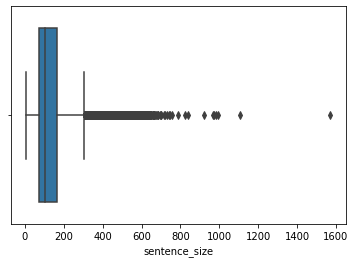

In [16]:
import seaborn as sns

sns.boxplot(x=df['sentence_size'])
df.sentence_size.describe()

count    25000.00000
mean       134.30628
std         99.41436
min          4.00000
25%         73.00000
50%        101.00000
75%        163.00000
max       1317.00000
Name: sentence_size, dtype: float64

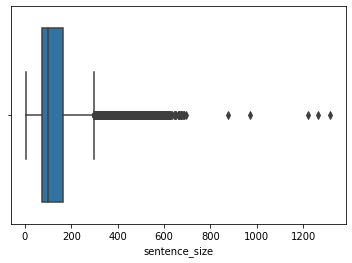

In [17]:
sns.boxplot(x=df_test['sentence_size'])
df_test.sentence_size.describe()

In [18]:

Q1_train = df.sentence_size.quantile(0.25)
Q3_train = df.sentence_size.quantile(0.75)
IQR_train = Q3_train - Q1_train
IQR_train, (Q1_train - 1.5 * IQR_train),(Q3_train + 1.5 * IQR_train), len(df[ df.sentence_size <= (Q3_train + 1.5 * IQR_train)]), len(df[ df.sentence_size > (Q3_train + 1.5 * IQR_train)])


(93.0, -65.5, 306.5, 23185, 1815)

In [19]:
Q1_test = df_test.sentence_size.quantile(0.25)
Q3_test = df_test.sentence_size.quantile(0.75)
IQR_test = Q3_test - Q1_test
IQR_test, (Q1_test - 1.5 * IQR_test),(Q3_test + 1.5 * IQR_test), len(df_test[ df_test.sentence_size <= (Q3_test + 1.5 * IQR_test)]), len(df_test[ df_test.sentence_size > (Q3_test + 1.5 * IQR_test)])


(90.0, -62.0, 298.0, 23179, 1821)

In [20]:
IQR_total = np.minimum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

298

In [21]:
if ETL_SENTENCE_SIZE == True :
    
    df = check_sentece_size(df,sequence_size)
    df_filtered=df.copy()
    df_filtered = df[df['sentence_size'] > 0] 
    df_filtered = df_filtered.reset_index().drop(["index"], axis = 1)
    
    df_test = check_sentece_size(df_test,sequence_size)
    df_test_filtered=df_test.copy()
    df_test_filtered = df_test[df_test['sentence_size'] > 0] 
    df_test_filtered = df_test_filtered.reset_index().drop(["index"], axis = 1)
    
    
    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(df_filtered.review.values.tolist())
    tokenizer.fit_on_texts(df_test_filtered.review.values.tolist())
    word_frequency= check_word_frequency(tokenizer)
    
    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
        
    df.to_pickle("./checkpoints/df.pkl")  
    df_test.to_pickle("./checkpoints/df_test.pkl")  
    
    df_filtered.to_pickle("./checkpoints/df_filtered.pkl")  
    df_test_filtered.to_pickle("./checkpoints/df_test_filtered.pkl") 
    
else:
    df = pd.read_pickle("./checkpoints/df.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test.pkl")
    
    df_filtered = pd.read_pickle("./checkpoints/df_filtered.pkl")
    df_test_filtered = pd.read_pickle("./checkpoints/df_test_filtered.pkl")
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
        


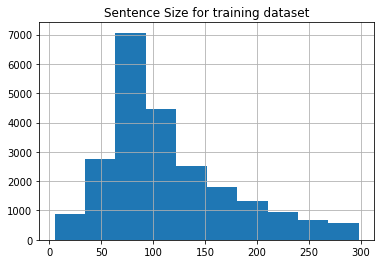

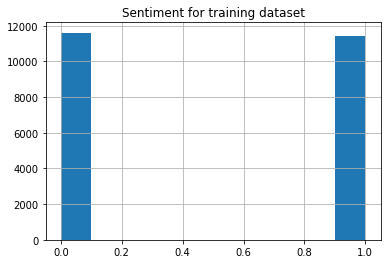

count    23046.000000
mean       114.384622
std         60.707644
min          5.000000
25%         72.000000
50%         97.000000
75%        146.000000
max        298.000000
Name: sentence_size, dtype: float64


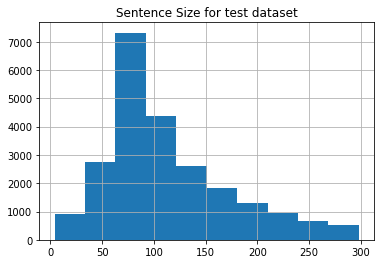

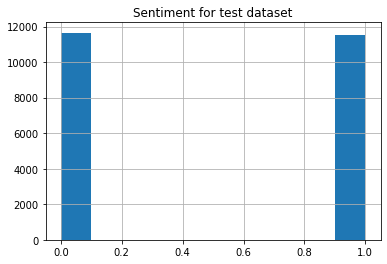

count    23179.000000
mean       112.844169
std         59.983230
min          4.000000
25%         72.000000
50%         96.000000
75%        143.000000
max        298.000000
Name: sentence_size, dtype: float64


In [22]:

plt.figure()
pd.Series(df_filtered.sentence_size).hist()
plt.title("Sentence Size for training dataset")

plt.figure()
pd.Series(df_filtered.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(df_filtered.sentence_size).describe())

plt.figure()
pd.Series(df_test_filtered.sentence_size).hist()
plt.title("Sentence Size for test dataset")

plt.figure()
pd.Series(df_test_filtered.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(df_test_filtered.sentence_size).describe())

In [23]:
df_filtered_naive = df_filtered.copy()
df_test_filtered_naive = df_test_filtered.copy()

df_filtered_naive.review = df_filtered.review.apply(lambda x : x.replace('.', ''))
df_test_filtered_naive.review = df_test_filtered.review.apply(lambda x : x.replace('.', ''))
df_filtered_naive

review  sentiment     id  \
0      story man unnatural feeling pig  start opening...          0      0   
1      bromwell high cartoon comedy  run time program...          1      1   
2      homelessness george carlin state issue year ne...          1      3   
3      brilliant act lesley ann warren  best dramatic...          1      4   
4      film lack something could put finger first cha...          0      5   
...                                                  ...        ...    ...   
23041  saw ' last night stockholm film festival one h...          0  24995   
23042  film pick pound turn rather good 23rd century ...          0  24996   
23043  christmas together actually come time raise jo...          1  24997   
23044  one dumb film ever see  rip nearly ever type t...          0  24998   
23045  work class romantic drama director martin ritt...          1  24999   

       sentence_size  
0               71.0  
1               86.0  
2              220.0  
3               97.0  
4               71.0  
...              ...  
23041          177.0  
23042          121.0  
23043           94.0  
23044           76.0  
23045          105.0  

[23046 rows x 4 columns]

In [24]:
word_sentiment_df = pd.DataFrame.from_dict(word_frequency, orient='index').reset_index()
word_sentiment_df.columns = ["words","frequency"]
df_filtered_naive["review_list"] = df_filtered_naive.review.apply(lambda x : tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))[0].split())
df_test_filtered_naive["review_list"] = df_test_filtered_naive.review.apply(lambda x : tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))[0].split())
word_sentiment_df

words  frequency
0               story      20522
1                 man       8821
2           unnatural         73
3             feeling       1836
4                 pig        175
...               ...        ...
41946         mcphail          2
41947         geilgud          1
41948  discouragement          1
41949       brookline          2
41950          bagger          1

[41951 rows x 2 columns]

In [25]:
import itertools
if TRAIN_WORD_SENTIMENT == True :   
    words_df = pd.DataFrame(columns = ["sent", "words"])

    sent_list = []
    words_list = []
    for i, (s, l) in  enumerate(zip(df_filtered_naive.sentiment, df_filtered_naive.review_list)):

        s = [s]*len(l)
        sent_list.append(s)
        words_list.append(l)
        
        if i %5000 == 0:
            print(i)

    
    for i, (s, l) in  enumerate(zip(df_test_filtered_naive.sentiment, df_test_filtered_naive.review_list)):
        s = [s]*len(l)
        sent_list.append(s)
        words_list.append(l)

        if i %5000 == 0:
            print(i)

    sent_list = list(itertools.chain(*sent_list))
    words_list = list(itertools.chain(*words_list))

    words_df = pd.DataFrame(columns = ["sent", "words"])
    words_df["sent"] = sent_list
    words_df["words"] =words_list

    tmp =words_df[words_df.sent < threshold].groupby(["words"]).agg({"words":"count"}).rename(columns={"words":"negative_frequence"}).reset_index()
    word_sentiment_df = pd.merge(word_sentiment_df,tmp, how="left", on ="words" )

    tmp =words_df[words_df.sent >= threshold].groupby(["words"]).agg({"words":"count"}).rename(columns={"words":"positive_frequence"}).reset_index()
    word_sentiment_df = pd.merge(word_sentiment_df,tmp, how="left", on ="words" )
    word_sentiment_df = word_sentiment_df.fillna(0)

    total_pos_words_freq = np.sum(word_sentiment_df.positive_frequence)
    total_neg_words_freq = np.sum(word_sentiment_df.negative_frequence)
    word_sentiment_df["prob_pos"] = word_sentiment_df.positive_frequence/total_pos_words_freq
    word_sentiment_df["prob_neg"] = word_sentiment_df.negative_frequence/total_neg_words_freq
    

    #Calculate smoothing 
    word_sentiment_df["word_pos_smoothing"] = (word_sentiment_df.positive_frequence + 1)/(total_pos_words_freq + len(word_sentiment_df[word_sentiment_df.positive_frequence >0]))
    word_sentiment_df["word_neg_smoothing"] = (word_sentiment_df.negative_frequence + 1)/(total_neg_words_freq + len(word_sentiment_df[word_sentiment_df.negative_frequence >0]))
    word_sentiment_df["ratio"] = word_sentiment_df["word_pos_smoothing"]/word_sentiment_df["word_neg_smoothing"]

    #Fixing numeric underflow
    word_sentiment_df["loglikelihood"] = word_sentiment_df.ratio.apply(lambda x : np.log(x))

    total_positive_sent = len(df_filtered_naive[df_filtered_naive.sentiment >= threshold]) + len(df_test_filtered_naive[df_test_filtered_naive.sentiment >= threshold])
    total_negative_sent = len(df_filtered_naive[df_filtered_naive.sentiment < threshold]) + len(df_test_filtered_naive[df_test_filtered_naive.sentiment < threshold])

    word_sentiment_df["prior"] = total_positive_sent/total_negative_sent
    word_sentiment_df["logprior"] = np.log(word_sentiment_df["prior"]) 
    
    word_sentiment_df["word_pos_log"] = word_sentiment_df.positive_frequence.apply(lambda x : np.log(x + 1))
    word_sentiment_df["word_neg_log"] = word_sentiment_df.negative_frequence.apply(lambda x : np.log(x + 1 ))

    word_sentiment_df.to_pickle("./checkpoints/word_sentiment_df.pkl")  
else:
    word_sentiment_df = pd.read_pickle("./checkpoints/word_sentiment_df.pkl")

0
5000
10000
15000
20000
0
5000
10000
15000
20000


# Naive sentiment analysis model

In [26]:
df_filtered_naive = df_filtered_naive.reset_index().drop(["index"], axis = 1)
df_test_filtered_naive = df_test_filtered_naive.reset_index().drop(["index"], axis = 1)
word_sentiment_df = word_sentiment_df.fillna(0) #word_sentiment_df.fillna(-1)
word_sentiment_df

words  frequency  negative_frequence  positive_frequence  \
0               story      20522              9095.0             11427.0   
1                 man       8821              3946.0              4875.0   
2           unnatural         73                60.0                13.0   
3             feeling       1836               737.0              1099.0   
4                 pig        175                95.0                80.0   
...               ...        ...                 ...                 ...   
41946         mcphail          2                 0.0                 2.0   
41947         geilgud          1                 1.0                 0.0   
41948  discouragement          1                 0.0                 1.0   
41949       brookline          2                 0.0                 2.0   
41950          bagger          1                 0.0                 1.0   

           prob_pos      prob_neg  word_pos_smoothing  word_neg_smoothing  \
0      5.024118e-03  3.911956e-03        4.943345e-03        3.852238e-03   
1      2.143395e-03  1.697260e-03        2.109184e-03        1.671590e-03   
2      5.715720e-06  2.580730e-05        6.055900e-06        2.583405e-05   
3      4.831982e-04  3.169996e-04        4.758207e-04        3.125496e-04   
4      3.517366e-05  4.086155e-05        3.503771e-05        4.065686e-05   
...             ...           ...                 ...                 ...   
41946  8.793416e-07  0.000000e+00        1.297693e-06        4.235090e-07   
41947  0.000000e+00  4.301216e-07        4.325643e-07        8.470180e-07   
41948  4.396708e-07  0.000000e+00        8.651286e-07        4.235090e-07   
41949  8.793416e-07  0.000000e+00        1.297693e-06        4.235090e-07   
41950  4.396708e-07  0.000000e+00        8.651286e-07        4.235090e-07   

          ratio  loglikelihood    prior  logprior  word_pos_log  word_neg_log  
0      1.283240       0.249388  0.98689 -0.013197      9.343822      9.115590  
1      1.261783       0.232526  0.98689 -0.013197      8.492080      8.280711  
2      0.234415      -1.450660  0.98689 -0.013197      2.639057      4.110874  
3      1.522385       0.420278  0.98689 -0.013197      7.003065      6.603944  
4      0.861791      -0.148743  0.98689 -0.013197      4.394449      4.564348  
...         ...            ...      ...       ...           ...           ...  
41946  3.064145       1.119769  0.98689 -0.013197      1.098612      0.000000  
41947  0.510691      -0.671991  0.98689 -0.013197      0.000000      0.693147  
41948  2.042763       0.714303  0.98689 -0.013197      0.693147      0.000000  
41949  3.064145       1.119769  0.98689 -0.013197      1.098612      0.000000  
41950  2.042763       0.714303  0.98689 -0.013197      0.693147      0.000000  

[41951 rows x 14 columns]

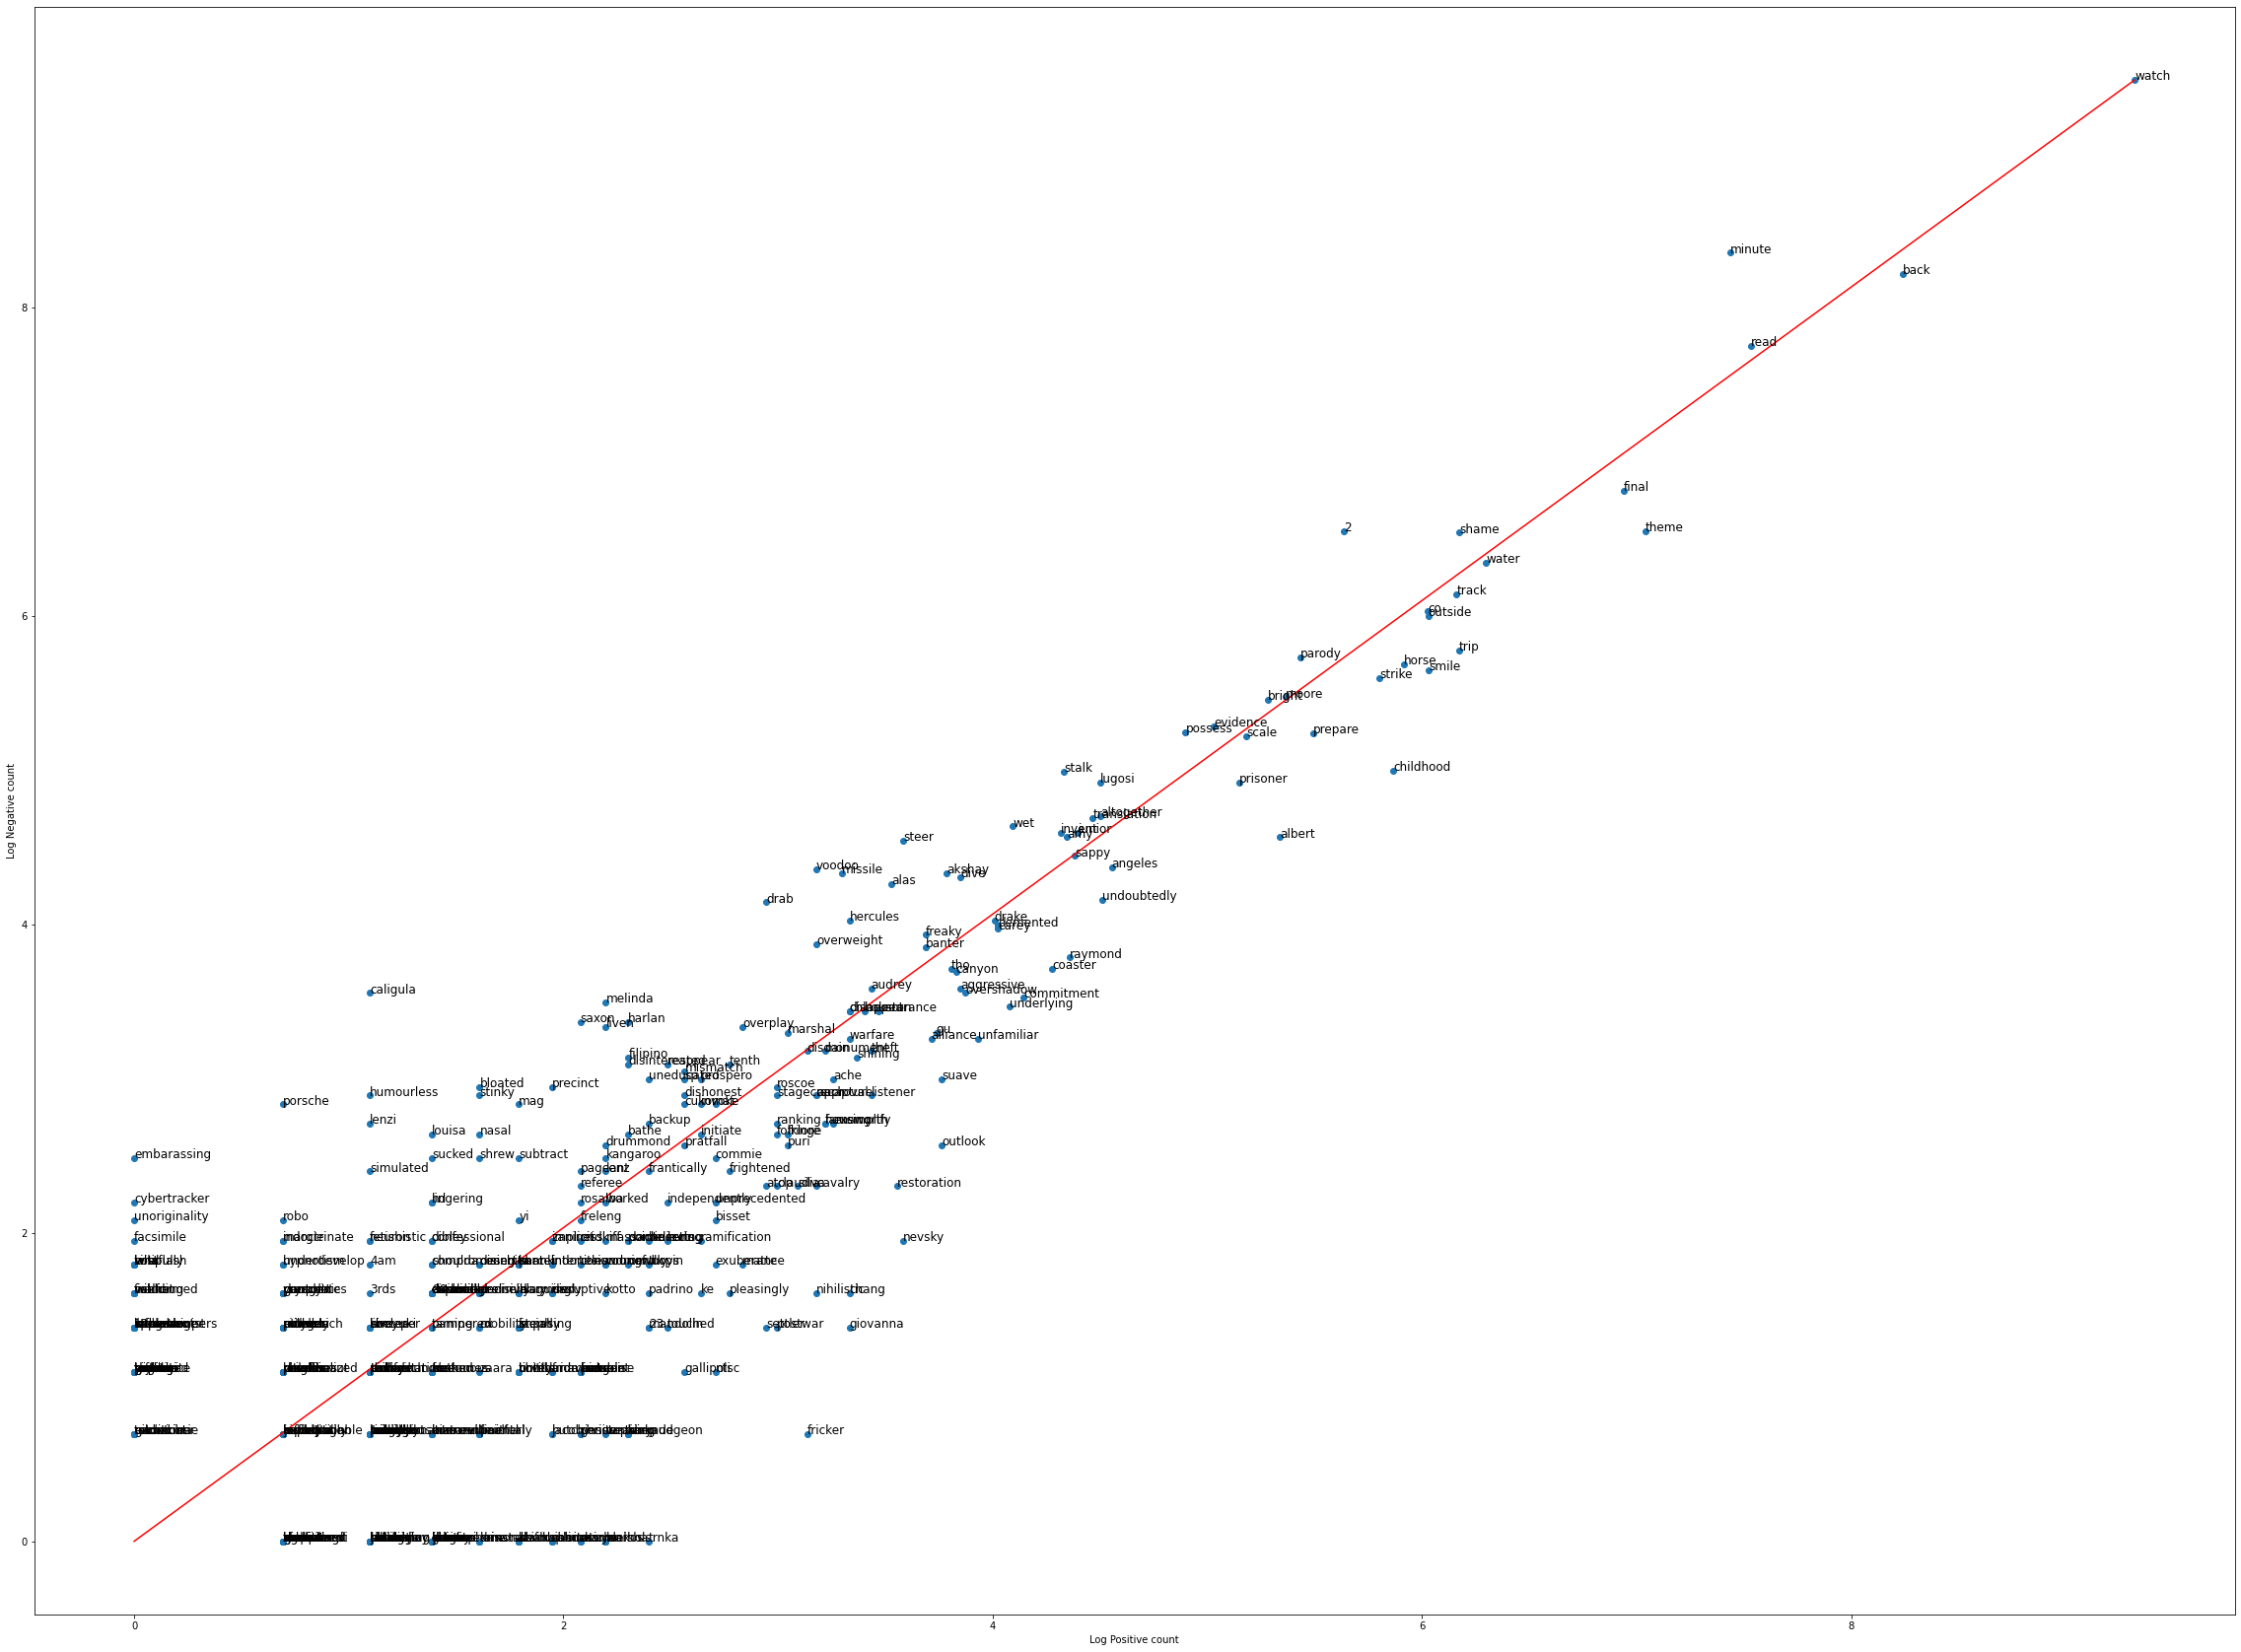

In [27]:
d = word_sentiment_df.sample(frac=0.01)    
plot_words(d)

In [28]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
tokenizer.fit_on_texts(df_filtered_naive.review.values.tolist())
tokenizer.fit_on_texts(df_test_filtered_naive.review.values.tolist())
word_frequency= check_word_frequency(tokenizer)

In [29]:
def naive_bayes_predict(test_sent, word_sentiment_df):
    # initialize probability to zero
    p = 0

    # add the logprior
    p += word_sentiment_df["logprior"].values[0]
    p += word_sentiment_df[word_sentiment_df.words.isin(test_sent)].loglikelihood.sum()
   
    return p

test_df_naive= df_test_filtered_naive.sample(frac=0.05)    
test_df_naive["sent_filtered"] = test_df_naive.sentiment.apply(lambda x: 1 if x>=threshold else 0 )

test_df_naive["prediction"] = test_df_naive.review_list.apply(lambda x : 1 if naive_bayes_predict(x,word_sentiment_df) >0 else 0)


test_df_naive

review  sentiment     id  \
16150  compare recent gore flick hostel movie remind ...          0  17418   
21289  hard believe people world actually think worth...          0  22958   
5040   film plain lovely  funny hell old hill  acting...          1   5411   
6343   series continue frustrate annoy  go drag anoth...          0   6816   
22682  'take fame ' 'you get serve ' roughly jam toge...          0  24446   
...                                                  ...        ...    ...   
3590   van sant copy hitchcock masterpiece shot shot ...          0   3870   
21050   single act  charlie wilson congressman real c...          1  22697   
2485   look film terrible  `` plot `` involve twin ne...          0   2678   
21595  anything bad movie want see  remember many ama...          0  23276   
12599  good early cronenberg horror film nothing basi...          0  13575   

       sentence_size                                        review_list  \
16150           98.0  [compare, recent, gore, flick, hostel, movie, ...   
21289          148.0  [hard, believe, people, world, actually, think...   
5040            71.0  [film, plain, lovely, funny, hell, old, hill, ...   
6343            79.0  [series, continue, frustrate, annoy, go, drag,...   
22682          144.0  [take, fame, you, get, serve, roughly, jam, to...   
...              ...                                                ...   
3590            60.0  [van, sant, copy, hitchcock, masterpiece, shot...   
21050           68.0  [single, act, charlie, wilson, congressman, re...   
2485            74.0  [look, film, terrible, plot, involve, twin, ne...   
21595           59.0  [anything, bad, movie, want, see, remember, ma...   
12599           46.0  [good, early, cronenberg, horror, film, nothin...   

       sent_filtered  prediction  
16150              0           0  
21289              0           0  
5040               1           1  
6343               0           0  
22682              0           0  
...              ...         ...  
3590               0           0  
21050              1           1  
2485               0           0  
21595              0           0  
12599              0           0  

[1159 rows x 7 columns]

In [30]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_df_naive.prediction.tolist(), test_df_naive.sent_filtered)
m.result().numpy()

0.9240725

In [31]:
test_elements_index = np.random.choice(1000, 200, replace=False) 
print("devtest_elements_index length : ",(test_elements_index))

test_df_naive_filtered = df_test_filtered_naive[df_test_filtered_naive.index.isin(test_elements_index)] 
df_test_noprocess_filtered = df_test_noprocess.copy()

test_df_naive_filtered["review_list"] = test_df_naive_filtered.review.apply(lambda x : x.split())
test_df_naive_filtered["sent_filtered"] = test_df_naive_filtered.sentiment.apply(lambda x: 1 if x>=threshold else 0 )
test_df_naive_filtered = test_df_naive_filtered.reset_index().drop(["index"], axis = 1)
test_df_naive_filtered

devtest_elements_index length :  [661 406 201 315  16 319 466 946 995 852 993 419 697  96 493 578 270 760
 102 113 277 193 767 526 116 629   2 413 198 877 971 313 258 496 321  81
 708 944 948 457 786 887 259 282 328 593 610 807 164 886 602 424 716 229
 421 371 709 485 131 394 933 250 974 784 613 487 894 168 148 765 818 751
 337 850 486  69 418 539 203 710 256  44 596 375 771 450 176 358 847 324
 230  43 362 622 761 601 682 868 327 378 984 292 220 809 511 640 667 481
 665 248 133 913 238 732 673 967 431 454 623 901 943 463 636 653 142 849
 895 752 167 236 642 216 859 490 506 978 931  12 224 605 988 574 553 222
 955 512 595 247 473 790 594 912 341 344 806 769 590 491  79 475 233 792
 213 186 538 778 615 101 858 370 962  30 685 308 744 729 936 865 278  65
 573 284  78 274 257 408 699 856 269 675 644 966 561  23 840  17  77 714
 354 827]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


review  sentiment    id  \
0    example majority action film  generic bore rea...          0     2   
1    german horror film one weird see  aware connec...          0    12   
2    movie amazing fact real people portray real li...          1    16   
3    '' tokyo eye `` tell <NUMBER> year old japanes...          0    17   
4    tell serious boozer drink budweiser  many suic...          0    24   
..                                                 ...        ...   ...   
195  movie almost unknown good  lonely danish town ...          1  1059   
196  lame rip quatermass <NUMBER> first half deadly...          0  1066   
197  dead spot picture postcard superficiality `` a...          1  1070   
198  rocket government experiment effect cosmic ray...          0  1075   
199  flawlessly direct write perform film quiet unp...          1  1077   

     sentence_size                                        review_list  \
0            139.0  [example, majority, action, film, generic, bor...   
1             86.0  [german, horror, film, one, weird, see, aware,...   
2             89.0  [movie, amazing, fact, real, people, portray, ...   
3             82.0  ['', tokyo, eye, ``, tell, <NUMBER>, year, old...   
4            150.0  [tell, serious, boozer, drink, budweiser, many...   
..             ...                                                ...   
195          228.0  [movie, almost, unknown, good, lonely, danish,...   
196          260.0  [lame, rip, quatermass, <NUMBER>, first, half,...   
197          240.0  [dead, spot, picture, postcard, superficiality...   
198          148.0  [rocket, government, experiment, effect, cosmi...   
199          225.0  [flawlessly, direct, write, perform, film, qui...   

     sent_filtered  
0                0  
1                0  
2                1  
3                0  
4                0  
..             ...  
195              1  
196              0  
197              1  
198              0  
199              1  

[200 rows x 6 columns]

In [32]:
df_test_noprocess_filtered["sent_filtered"] = df_test_noprocess_filtered.sentiment.apply(lambda x: 1 if x>=threshold else 0 )
df_test_noprocess_filtered

review  sentiment     id  \
0      i went and saw this movie last night after bei...          1      0   
1      once again mr. costner has dragged out a movie...          0      1   
2      this is an example of why the majority of acti...          0      2   
3      actor turned director bill paxton follows up h...          1      3   
4      first of all i hate those moronic rappers, who...          0      4   
...                                                  ...        ...    ...   
24995  from the start of "the edge of love", the view...          1  24995   
24996  this movie, with all its complexity and subtle...          1  24996   
24997  four things intrigued me as to this film - fir...          0  24997   
24998  david bryce's comments nearby are exceptionall...          0  24998   
24999  i've seen this story before but my kids haven'...          1  24999   

       sent_filtered  
0                  1  
1                  0  
2                  0  
3                  1  
4                  0  
...              ...  
24995              1  
24996              1  
24997              0  
24998              0  
24999              1  

[25000 rows x 4 columns]

In [33]:
print('Truth Predicted Tweet')
index = 0
for i in range(len(test_df_naive_filtered)):
    
    y_hat = naive_bayes_predict(test_df_naive_filtered.review_list.values[i], word_sentiment_df)
    
    y = df_test_noprocess_filtered.sent_filtered.values[i]
    x  = df_test_noprocess_filtered[(df_test_noprocess_filtered.id == test_df_naive_filtered.id.values[i])].review.tolist()
    
    if y != (np.sign(y_hat) > 0) and index <=10:

        aux = test_df_naive_filtered.review.values[i]
        print(f'ID : {test_df_naive_filtered.id.values[i]}  Y : {y}\ny_hat:{int(np.sign(y_hat)> 0 )} :  \nReal : {x} \n\nProcessed : {aux} \n ------------------------\n')
        index += 1

Truth Predicted Tweet
ID : 2  Y : 1
y_hat:0 :  
Real : ["this is an example of why the majority of action films are the same. generic and boring, there's really nothing worth watching here. a complete waste of the then barely-tapped talents of ice-t and ice cube, who've each proven many times over that they are capable of acting, and acting well. don't bother with this one, go see new jack city, ricochet or watch new york undercover for ice-t, or boyz n the hood, higher learning or friday for ice cube and see the real deal. ice-t's horribly cliched dialogue alone makes this film grate at the teeth, and i'm still wondering what the heck bill paxton was doing in this film? and why the heck does he always play the exact same character? from aliens onward, every film i've seen with bill paxton has him playing the exact same irritating character, and at least in aliens his character died, which made it somewhat gratifying...<br /><br />overall, this is second-rate action trash. there are co

In [34]:
y_out=[]
for i in range(len(df_test_filtered_naive)):
    y_hat = naive_bayes_predict(df_test_filtered_naive.review.values[i].split(), word_sentiment_df)
    y_out.append(int(np.sign(y_hat) > 0))


In [35]:
yhat = np.array(y_out).reshape((len(y_out),1))

y_test = df_test_filtered_naive.sentiment.values
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

print("AUC",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy())
confusion_matrix(list(y_test),list(yhat))

AUC 0.8845522  | Precision :  0.9148764  | Recall :  0.8828938


array([[10704,   947],
       [ 1350, 10178]])

In [36]:
test_df_naive_filtered

review  sentiment    id  \
0    example majority action film  generic bore rea...          0     2   
1    german horror film one weird see  aware connec...          0    12   
2    movie amazing fact real people portray real li...          1    16   
3    '' tokyo eye `` tell <NUMBER> year old japanes...          0    17   
4    tell serious boozer drink budweiser  many suic...          0    24   
..                                                 ...        ...   ...   
195  movie almost unknown good  lonely danish town ...          1  1059   
196  lame rip quatermass <NUMBER> first half deadly...          0  1066   
197  dead spot picture postcard superficiality `` a...          1  1070   
198  rocket government experiment effect cosmic ray...          0  1075   
199  flawlessly direct write perform film quiet unp...          1  1077   

     sentence_size                                        review_list  \
0            139.0  [example, majority, action, film, generic, bor...   
1             86.0  [german, horror, film, one, weird, see, aware,...   
2             89.0  [movie, amazing, fact, real, people, portray, ...   
3             82.0  ['', tokyo, eye, ``, tell, <NUMBER>, year, old...   
4            150.0  [tell, serious, boozer, drink, budweiser, many...   
..             ...                                                ...   
195          228.0  [movie, almost, unknown, good, lonely, danish,...   
196          260.0  [lame, rip, quatermass, <NUMBER>, first, half,...   
197          240.0  [dead, spot, picture, postcard, superficiality...   
198          148.0  [rocket, government, experiment, effect, cosmi...   
199          225.0  [flawlessly, direct, write, perform, film, qui...   

     sent_filtered  
0                0  
1                0  
2                1  
3                0  
4                0  
..             ...  
195              1  
196              0  
197              1  
198              0  
199              1  

[200 rows x 6 columns]

# Deep learning approach

In [37]:
df_filtered.sentiment.unique()

array([0, 1])

In [38]:
df_filtered = (df_filtered.dropna()).reset_index().drop(["index"], axis = 1)
df_test_filtered = (df_test_filtered.dropna()).reset_index().drop(["index"], axis = 1)
df_test_filtered

review  sentiment     id  \
0      go saw movie last night coax friend mine . adm...          1      0   
1      mr . costner drag movie far long necessary . a...          0      1   
2      example majority action film . generic bore re...          0      2   
3      actor turn director bill paxton follow promisi...          1      3   
4      first hate moronic rapper could act gun press ...          0      4   
...                                                  ...        ...    ...   
23174  basic genre thriller intercut uncomfortable me...          0  24994   
23175  movie complexity subtlety make one thought pro...          1  24996   
23176  four thing intrigue film firstly star carly po...          0  24997   
23177  david bryce comment nearby exceptionally well ...          0  24998   
23178  see story kid . boy troubled past join militar...          1  24999   

       sentence_size  
0               80.0  
1               83.0  
2              139.0  
3              213.0  
4              124.0  
...              ...  
23174          150.0  
23175           82.0  
23176           77.0  
23177          254.0  
23178          134.0  

[23179 rows x 4 columns]

In [39]:
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
ft.get_dimension()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 300 is different from 0)

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
tokenizer.fit_on_texts(df_filtered.review.values.tolist())
tokenizer.fit_on_texts(df_test_filtered.review.values.tolist())
_, vocab_len,sequences,word_index= tokenize_data(tokenizer, df_filtered)
print("Train Vocab length : It should be the complete one : ",vocab_len)
_, vocab_len_test,sequences_test,word_index_test= tokenize_data(tokenizer, df_test_filtered)
print("Test Vocab length. It should be the complete one : ",vocab_len_test)

In [ ]:
embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)
print(embeddings_matrix)

In [ ]:
x, y = create_trainingdev_set(sequences,df_filtered,sequence_size, False)
x_dev,y_dev,x_test,y_test = create_trainingdev_set(sequences_test,df_test_filtered,sequence_size,True)
y_dev

# Start training process

### Run training process 


In [ ]:

from gc import callbacks
import keras_tuner as kt

def get_model_dynamic(best_hps):
    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    inp = Input(batch_shape = (None,sequence_size,), name="X")

    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, best_hps["emb_dim"])
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,best_hps["emb_dim"],vocab_len)

    X = Embedding(input_dim = vocab_len, output_dim = best_hps["emb_dim"], input_length = sequence_size ,name ="emb_layer",  weights=[embeddings_matrix_tmp], trainable=False, mask_zero=True) (inp)# Use masking to handle the variable sequence lengths
    #X = SpatialDropout1D(best_hps.get('SpatialDropout1D_1'))(X)
    X = (LSTM(best_hps.get('units_0'),  dropout=best_hps.get('Dropout_0'), return_sequences=False))(X)

    X = BatchNormalization()(X)
    X = Dropout(best_hps.get('Dropout_1'))(X)
    X = Dense(best_hps.get('units_1'), activation='relu')(X)


    Z = Dense(classN, activation='sigmoid')(X)

    model =  Model(inputs = inp, outputs=Z )
    model.summary()

    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=best_hps.get('learning_rate')), metrics =[tf.keras.metrics.BinaryAccuracy(),pr,p,r,tf.keras.metrics.AUC()])

    return model

def get_model_tunning(hp):

    hp_units_0 = hp.Int('units_0', min_value=32, max_value=256, step=32)
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    hp_drop_0 = hp.Choice('Dropout_0', values=[ 0.2, 0.3, 0.4, 0.5])
    hp_drop_1 = hp.Choice('Dropout_1', values=[ 0.2, 0.3, 0.4, 0.5])
    #hp_SpatialDropout1D_1 = hp.Choice('SpatialDropout1D_1', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_emb_dim = hp.Choice('emb_dim', values=[ 50, 100, 200])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)


    inp = Input(batch_shape = (None,sequence_size,), name="X")
    
    X = Embedding(input_dim = vocab_len, output_dim = hp_emb_dim, input_length = sequence_size ,name ="emb_layer",  weights=[embeddings_matrix_tmp], trainable=False, mask_zero=True) (inp)# Use masking to handle the variable sequence lengths
    #X = SpatialDropout1D(hp_SpatialDropout1D_1)(X)
    X = (LSTM(hp_units_0, dropout=hp_drop_0, return_sequences=False))(X)

    X = BatchNormalization()(X)
    X = Dropout(hp_drop_1)(X)
    X = Dense(hp_units_1, activation='relu')(X)


    Z = Dense(classN, activation='sigmoid')(X)
    
    model =  Model(inputs = inp, outputs=Z )
    
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=hp_learning_rate), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
    
    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective=kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = max_trials,
        directory=r"Hyperparam_tunning",
        project_name='keras_tunning'
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=30)
if TUNNING:
    tuner.search(x[0], y,  epochs=300, batch_size=batchsize, validation_data = (x_dev[0],y_dev), verbose =2, callbacks=[stop_early]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


In [ ]:
best_hps["units_0"],best_hps["units_1"],best_hps["Dropout_0"],best_hps["Dropout_0"],best_hps["learning_rate"]
#(64, 64, 0.2, 0.2, 0.5, 0.005)

In [ ]:
model_dynamic = get_model_dynamic(best_hps)
if FIT_MODEL:
    
    model_dynamic.fit(x[0], y, 
              batch_size=batchsize, 
              epochs=300,
              shuffle=True,
              validation_data = (x_dev[0],y_dev),
              callbacks=[PlotLossesCallback() ,stop_early]
             )
    
    model_dynamic.save('./checkpoints_dynamic/model_dynamic')
else:
    model_dynamic = tf.keras.models.load_model('./checkpoints_dynamic/model_dynamic')

In [ ]:
yhat =model_dynamic.predict(x_test[0][0:100])
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
yhat

y_test = y_test.reshape((len(y_test),1))
y_test
print("x 1º line : "+str(x))
print("y : ",y) 
print("y_test : ",y_test) 

In [ ]:

yhat =model_dynamic.predict(x_test)
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")
print()

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

base_pr = pr(y_test, yhat).numpy()
base_p = p.result().numpy()
base_r = r.result().numpy()
print("AUC",base_pr," | Precision : ",base_p, " | Recall : ",base_r)


In [ ]:

confusion_matrix(list(y_test),list(yhat))

In [ ]:

base_tn, base_fp, base_fn, base_tp = confusion_matrix(list(y_test),list(yhat)).ravel()
base_tn, base_fp, base_fn, base_tp



In [ ]:
def print_predictions(X, pred):
    for i in range(len(X)):
        xx = [tokenizer.index_word.get(ind) for ind in X[i] if tokenizer.index_word.get(ind) is not None]
        print(' '.join(xx), "Prediction :", int(pred[i])," - Real :",y_test[i][0],"\n")
        
        if i==10:
            break

print_predictions(x_test[0], yhat)

# Attention model

In [ ]:
batchsize = 32
emb_dim = 300
epochs = 100
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
ft.get_dimension()

embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)
dataset = tf.data.Dataset.from_tensor_slices((x[0],y.reshape((len(y),1))))
for i,o in dataset.take(3):
    print("Input : ",i.numpy(), " ->",i.numpy().shape)
    print("Output : ",o.numpy(), " ->",o.numpy().shape,"\n\n")
    
    
dataset = dataset.shuffle(buffer_size=10000).batch(batchsize, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print("Batched dataset ... \n")
for i,o in dataset.take(1):
    print("Input : ",i)
    print("Output : ",o,"\n\n")

ds_len = len(list(dataset))
val_size = int(0.07 * ds_len)
val_dataset = dataset.take(val_size) 
train_dataset = dataset.skip(val_size)

train_size = len(list(train_dataset))

print(ds_len,"-->",train_size,"--->",val_size,"/",ds_len*batchsize)

dataset = train_dataset
ds_len = train_size

test_dataset = tf.data.Dataset.from_tensor_slices((x_test[0],y_test.reshape((len(y_test),1))))
test_dataset = test_dataset.batch(1)

In [ ]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence, figsize  =(10, 10)):
  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split() + ['<eos>']
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:

class SelfMaskedDotProductAttention(tf.keras.Model): 
    def __init__(self):
        super(SelfMaskedDotProductAttention, self).__init__()


    def call(self, q, k, v, padding_mask= None, look_ahead_mask= None):
        
        PRINT_SHAPE= False
                
        matmul_qk = tf.matmul(q, k, transpose_b=True) 

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if PRINT_SHAPE : print("weight shape : ", scaled_attention_logits.shape," - [batch_size, Tq, Tv]")
        
        if padding_mask is not None:
            padding_mask = tf.expand_dims(padding_mask, 1)
            scaled_attention_logits = tf.where(padding_mask, scaled_attention_logits, tf.experimental.numpy.full_like(scaled_attention_logits,  -1e9))

        if look_ahead_mask is not None:
            scaled_attention_logits += (look_ahead_mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
        if PRINT_SHAPE : print("attention_weights / values : ",attention_weights.shape, v.shape)

        context_vector = tf.matmul(attention_weights, v)

        if PRINT_SHAPE : print("context_vector shape : ", context_vector.shape)

        return context_vector, attention_weights


class MaskedLossCustom(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_custom'
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)
    
auc = tf.keras.metrics.AUC(curve="PR")
p = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()



class Sentiment_Attention_v2(tf.keras.Model):
    def __init__(self, unit_lstm, unit_dropout_1, unit_dropout_2, unit_dense, vocab_len, emb_dim, embeddings_matrix, classes, input_length, causal_mask_enabled=True):
        super(Sentiment_Attention_v2, self).__init__()

        
        self.embedding_layer = Embedding(input_dim = vocab_len, output_dim = emb_dim, input_length = input_length ,name ="emb_layer",  weights=[embeddings_matrix], trainable=False, mask_zero=True)# Use masking to handle the variable sequence lengths
        self.lstm = LSTM(unit_lstm,  return_sequences=True, dropout=unit_dropout_1, return_state = True)#dropout=0.5,  1024
        self.batch_norm = BatchNormalization()
        self.drop = Dropout(unit_dropout_2)
        self.d0 = Dense(unit_dense, activation='relu')
        self.d = Dense(classes, activation='sigmoid')

        self.dot_attention = SelfMaskedDotProductAttention()
        self.causal_mask_enabled = causal_mask_enabled


    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  
    
    def call(self, inputs):
        input_mask = (inputs != 0)
        x = self.embedding_layer(inputs)

        last_state = self.lstm.get_initial_state(x)
        lstm_out, h_state, c_state = self.lstm(x, initial_state=last_state ) 

        if self.causal_mask_enabled == False :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
        x = tf.reduce_sum(context_vector, axis = 1)
        x = self.batch_norm(x)
        x = self.d0(x)
        pred = self.d(x)
                       
        return pred

    def predict_sentiment(self, inputs, input_mask = None, last_state= None):
        
        x = self.embedding_layer(inputs)
        

        if last_state is None:
            last_state = self.lstm.get_initial_state(x)
        
        lstm_out, h_state, c_state = self.lstm(x, initial_state=last_state ) 

        if self.causal_mask_enabled == False :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
        x = tf.reduce_sum(context_vector, axis =1)
        x = self.batch_norm(x)
        x = self.drop(x)
        x = self.d0(x)
        pred = self.d(x)
                       
        return pred, (h_state, c_state), attention_weights, lstm_out, context_vector 



class Sentiment_Attention(tf.keras.Model):
    def __init__(self, lstm_unit, dropout_0, dense_unit, vocab_len, emb_dim, embeddings_matrix, classes, input_length, causal_mask_enabled=True):
        super(Sentiment_Attention, self).__init__()

        
        self.embedding_layer = Embedding(input_dim = vocab_len, output_dim = emb_dim, input_length = input_length ,name ="emb_layer",  weights=[embeddings_matrix], trainable=False, mask_zero=True)# Use masking to handle the variable sequence lengths
        self.lstm = LSTM(lstm_unit,   return_sequences=True, return_state = True)#512
        self.batch_norm = BatchNormalization()
        self.drop = Dropout(dropout_0)
        self.d0 = Dense(dense_unit, activation='relu')
        self.d = Dense(classes, activation='sigmoid')

        self.dot_attention = SelfMaskedDotProductAttention()
        self.causal_mask_enabled = causal_mask_enabled


    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  
    
    def call(self, inputs, input_mask = None, last_state= None):
        
        x = self.embedding_layer(inputs)
        #x = self.spatial(x)

        if last_state is None:
            last_state = self.lstm.get_initial_state(x)
        
        lstm_out, h_state, c_state = self.lstm(x, initial_state=last_state ) 

        if self.causal_mask_enabled == False :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
        x = tf.reduce_sum(context_vector, axis = -1)
        x = self.batch_norm(x)
        #x = self.drop(x)
        x = self.d0(x)
        pred = self.d(x)
                       
        return pred, (h_state, c_state), attention_weights, lstm_out, context_vector 

class ModelClass(tf.keras.Model):
    def __init__(self, lstm_unit, dropout_0, dense_unit, vocab_len, emb_dim, embeddings_matrix, classes, sequence_size, causal_mask_enabled=True ):
        super(ModelClass, self).__init__()
        self.vocab_size = vocab_len
        self.sequence_size = sequence_size
        self.sentiment_attention_model = Sentiment_Attention(lstm_unit, dropout_0, dense_unit, vocab_len, emb_dim, embeddings_matrix, classes, sequence_size, causal_mask_enabled)
        self.use_tf_function = True

    def call(self, inputs, last_state = None ):
        input_mask = inputs != 0
        pred, last_state , attention_weights, last_activation, last_attention  = self.sentiment_attention_model(inputs,  input_mask, last_state)

        return pred, last_state , attention_weights, last_activation, last_attention

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)


    def _train_step(self, inputs):
        x, y = inputs  
        target_mask = y != 0     
        last_state= None
        last_activation = None
        last_attention = None

        with tf.GradientTape() as tape:
            loss = tf.constant(0.0)
            acc = []
            auc_list = []
            r_list = []
            p_list = []

            input_mask = x != 0
            pred, last_state , attention_weights, last_activation, last_attention  = self.sentiment_attention_model(x,  input_mask, last_state)

            loss += self.loss(y, pred)
            self.compiled_metrics.update_state(y, pred)
            acc.append(self.metrics[0].result())

            auc.update_state(y, pred)
            auc_list.append(auc.result())

            r.update_state(y, pred)
            r_list.append(r.result())

            p.update_state(y, pred)
            p_list.append(p.result())

        average_loss = loss 
        average_acc  = tf.reduce_mean(acc)
        average_auc  = tf.reduce_mean(tf.convert_to_tensor(auc_list) )
        average_r  = tf.reduce_mean(tf.convert_to_tensor(r_list) )
        average_p  = tf.reduce_mean(tf.convert_to_tensor(p_list) )
            
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc   for m in self.metrics}
        m["loss"] = average_loss
        m["auc"] = average_auc
        m["recall_avrg"] = average_r
        m["precision_avrg"] = average_p
    
        return m
    
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, sequence_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, 1])]])#
                                
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)


    def test_step(self, inputs):
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            return self._test_step(inputs)

    
    def _test_step(self, inputs):
        x, y = inputs  
        
        input_mask = None

        loss_val = tf.constant(0.0)
        acc = []
        auc_list = []
        r_list = []
        p_list = []

        last_state= None
        input_mask = x != 0
        
        pred, last_state , attention_weights, last_activation, last_attention  = self.sentiment_attention_model(x, input_mask, last_state)
        
        loss_val += self.loss(y, pred)

        self.compiled_metrics.update_state(y, pred)
        acc.append(self.metrics[0].result())

        auc.update_state(y, pred)
        auc_list.append(auc.result())

        r.update_state(y, pred)
        r_list.append(r.result())

        p.update_state(y, pred)
        p_list.append(p.result())


        average_loss = loss_val
        average_acc  = tf.reduce_mean(acc)
        average_auc  = tf.reduce_mean(tf.convert_to_tensor(auc_list) )
        average_r  = tf.reduce_mean(tf.convert_to_tensor(r_list) )
        average_p  = tf.reduce_mean(tf.convert_to_tensor(p_list) )

        m = {m.name: average_acc  for m in self.metrics}
        m["loss"] = average_loss
        m["auc"] = average_auc
        m["recall_avrg"] = average_r
        m["precision_avrg"] = average_p
        
        return m


    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, sequence_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, 1])
                                ]])
    def _tf_test_step(self, inputs):
        return self._test_step(inputs)



In [ ]:
emb_layer = Embedding(input_dim=vocab_len, input_length = sequence_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
attention_layer = SelfMaskedDotProductAttention()
query = emb_layer(i)
values = emb_layer(i)

context_vector, attention_weights_nomask = attention_layer(query,values,values)
context_vector, attention_weights = attention_layer(query,values,values, padding_mask=(i != 0))
context_vector, attention_weightsv2 = attention_layer(query,values,values, padding_mask=(i != 0), look_ahead_mask= (1 - tf.linalg.band_part(tf.ones((i.shape[1], i.shape[1])), -1, 0)))

plt.figure(figsize=(14,7))
plt.subplot(2, 2, 1)
plt.pcolormesh(attention_weights_nomask[0])#[ :mask_size,:mask_size]
plt.title('Attention weights - Not mask')

plt.subplot(2, 2, 2)
plt.pcolormesh(attention_weights[0])#[ :mask_size,:mask_size]
plt.title('Attention weights - Not causal')

plt.subplot(2, 2, 3)
plt.pcolormesh(attention_weightsv2[0])#[ :mask_size,:mask_size]
plt.title('Attention weights 1')

plt.subplot(2, 2, 4)
plt.pcolormesh(i != 0)
plt.title('Mask')

sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))

In [ ]:

def get_attention_v2_tunning(hp):

    hp_unit_lstm = hp.Int('unit_lstm', min_value=32, max_value=512, step=32)
    hp_unit_dropout_1 = hp.Choice('unit_dropout_1', values=[ 0.1, 0.3, 0.5])
    hp_unit_dropout_2 = hp.Choice('unit_dropout_2', values=[ 0.1, 0.3, 0.5])
    hp_unit_dense = hp.Int('unit_dense', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    hp_emb_dim = hp.Choice('emb_dim', values=[ 100, 200,300])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)


    model = Sentiment_Attention_v2(hp_unit_lstm, hp_unit_dropout_1, hp_unit_dropout_2, hp_unit_dense, vocab_len, hp_emb_dim, embeddings_matrix_tmp, classN, sequence_size, causal_mask_enabled=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=hp_learning_rate), metrics =[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
    
    return model


tuner_att_v2 = kt.BayesianOptimization(
        get_attention_v2_tunning,
        objective=kt.Objective('val_auc', direction="max"),#'val_binary_accuracy',
        max_trials = max_trials,
        directory=r"Hyperparam_att_v2_tunning",
        project_name='Hyperparam_att_v2_tunning'
    )


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=30)

if TUNNING_ATTENTION_V2:
    tuner_att_v2.search(dataset,  epochs=100, batch_size=batchsize, validation_data = val_dataset, verbose =2, callbacks=[stop_early]) 


best_hps_att_v2=tuner_att_v2.get_best_hyperparameters(num_trials=1)[0]
best_hps_att_v2




In [ ]:
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, best_hps_att_v2["emb_dim"])
embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,best_hps_att_v2["emb_dim"],vocab_len)

sentiment_MODEL_V2 = Sentiment_Attention_v2(best_hps_att_v2["unit_lstm"], best_hps_att_v2["unit_dropout_1"], best_hps_att_v2["unit_dropout_2"], best_hps_att_v2["unit_dense"], vocab_len, best_hps_att_v2["emb_dim"], embeddings_matrix_tmp, classN, sequence_size, causal_mask_enabled=True)
sentiment_MODEL_V2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=best_hps_att_v2["learning_rate"]), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])#Adam(learning_rate=best_hps.get('learning_rate'))

i, o = x[0][0:2], y[0:2] 
i = i[:,0:100]

mask_size = np.count_nonzero((i != 0))
print(i.shape, o.shape, mask_size)
pred = sentiment_MODEL_V2(i)
pred, states, attention_weights, lstm_out, context_vector  = sentiment_MODEL_V2.predict_sentiment(i,input_mask = (i != 0))
sentiment_MODEL_V2.summary()

In [ ]:
best_hps_att_v2["unit_lstm"], best_hps_att_v2["unit_dropout_1"], best_hps_att_v2["unit_dropout_2"], best_hps_att_v2["unit_dense"], vocab_len, best_hps_att_v2["emb_dim"]

In [ ]:
if FIT_ATTENTION_MODEL:
    history_attention = sentiment_MODEL_V2.fit( 
                dataset,
                batch_size = batchsize, 
                epochs= epochs*2,#epochs,#400
                shuffle=True,
                callbacks=[PlotLossesCallback(), stop_early], 
                validation_data=val_dataset, 
                validation_steps=10)


    sentiment_MODEL_V2.save_weights("./checkpoints_att/sentiment_attention_model_ckpt")

    with open('./checkpoints_att/history_attention.pickle', 'wb') as handle:
        pickle.dump(history_attention.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:

    print("Loading saved data ...")

    sentiment_MODEL_V2.load_weights("./checkpoints_att/sentiment_attention_model_ckpt")

    with open('./checkpoints_att/history_attention.pickle', 'rb') as handle:
        history_attention = pickle.load(handle)
        plt.figure()
        plt.plot(history_attention['binary_accuracy'])
        plt.plot(history_attention['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_attention['loss'])
        plt.plot(history_attention['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()


In [ ]:
if MAKE_PREDICTION:
    y_hat_list = []
    counter= 0
    for i, o in test_dataset.take(len(x_test[0])):
        if counter%1000 ==0 :
            print(counter)
        yhat, last_state , attention_weights, last_activation, last_attention = sentiment_MODEL_V2.predict_sentiment(i)
        y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
        counter +=1
        
    y_test = y_test.reshape((len(y_test),1))
    yhat = np.array(y_hat_list).reshape((len(y_test),1))

    pr = tf.keras.metrics.AUC(curve="PR")

    p = tf.keras.metrics.Precision()
    p.update_state(y_test,yhat)

    r = tf.keras.metrics.Recall()
    r.update_state(y_test,yhat)

    print("With Attention : AUC",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy())
    print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)



In [ ]:
if MAKE_PREDICTION:
    sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
    plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))

In [ ]:

def get_attention_tunning(hp):

    hp_unit_lstm = hp.Int('lstm_unit', min_value=32, max_value=512, step=32)
    hp_unit_dropout_0 = hp.Choice('dropout_0', values=[ 0.1, 0.3,  0.5])
    hp_unit_dense = hp.Int('unit_dense', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    hp_emb_dim = hp.Choice('emb_dim', values=[ 100, 200,300])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)


    model = ModelClass(hp_unit_lstm, hp_unit_dropout_0,  hp_unit_dense, vocab_len, hp_emb_dim, embeddings_matrix_tmp, classN, sequence_size, causal_mask_enabled=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=hp_learning_rate), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
    
    return model



tuner_att = kt.BayesianOptimization(
        get_attention_tunning,
        objective=kt.Objective('val_auc', direction="max"),#'val_binary_accuracy',
        max_trials = max_trials,
        directory=r"Hyperparam_att_tunning",
        project_name='keras_tunning_att'
    )
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=30)

if TUNNING_ATTENTION:
    tuner_att.search(dataset,  epochs=100, batch_size=batchsize, validation_data = val_dataset, verbose =0, callbacks=[stop_early]) #epochs


best_hps_att=tuner_att.get_best_hyperparameters(num_trials=1)[0]
best_hps_att


In [ ]:
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, best_hps_att["emb_dim"])
embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,best_hps_att["emb_dim"],vocab_len)

sentiment_model = ModelClass(best_hps_att["lstm_unit"], best_hps_att["dropout_0"],best_hps_att["unit_dense"], vocab_len, best_hps_att["emb_dim"], embeddings_matrix_tmp, classN, sequence_size, causal_mask_enabled=False )
sentiment_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=best_hps_att["learning_rate"]), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])

# if FIT_ATTENTION_MODEL:
#     sentiment_model.use_tf_function = False
#     for i, o in dataset.take(1):
#         print(sentiment_model.train_step([i, o]))
#         print(sentiment_model.test_step([i, o]))
#     print()

#     sentiment_model.use_tf_function = True
#     for i, o in dataset.take(2):
#         print(sentiment_model.train_step([i, o]))
#         print(sentiment_model.test_step([i, o]))
#     print()


In [ ]:
if FIT_ATTENTION_MODEL:
    history = sentiment_model.fit( 
                dataset,
                batch_size = batchsize, 
                epochs=400,#epochs,#300,
                shuffle=True,
                callbacks=[PlotLossesCallback(), stop_early], 
                validation_data=val_dataset, 
                validation_steps=10)

    sentiment_model.save_weights("./checkpoints_sent_att/sentiment_model_ckpt")

    with open('./checkpoints_sent_att/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")

    sentiment_model.load_weights("./checkpoints_sent_att/sentiment_model_ckpt")

    with open('./checkpoints_sent_att/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()



In [ ]:
if MAKE_PREDICTION:
    yhat, last_state , attention_weights, last_activation, last_attention =sentiment_model(x_test[0][0:100])
    yhat = yhat.numpy()
    yhat[yhat >=0.5] = 1
    yhat[yhat < 0.5] = 0 
    yhat

    y_test = y_test.reshape((len(y_test),1))
    y_test
    print("x 1º line : "+str(x))
    print("y : ",y) 
    print("y_test : ",y_test) 

In [ ]:
if MAKE_PREDICTION:
    y_hat_list = []
    counter= 0
    for i, o in test_dataset.take(len(x_test[0])):
        if counter%1000 ==0 :
            print(counter)
        yhat, last_state , attention_weights, last_activation, last_attention = sentiment_model(i)
        y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
        counter +=1

    y_test = y_test.reshape((len(y_test),1))
    yhat = np.array(y_hat_list).reshape((len(y_test),1))


    pr = tf.keras.metrics.AUC(curve="PR")

    p = tf.keras.metrics.Precision()
    p.update_state(y_test,yhat)

    r = tf.keras.metrics.Recall()
    r.update_state(y_test,yhat)

    pr_att= pr(y_test, yhat).numpy()
    p_att =p.result().numpy()
    r_att = r.result().numpy()
    print("With Attention : AUC",pr_att," | Precision : ",p_att, " | Recall : ",r_att)
    print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)

    tn_att, fp_att, fn_att, tp_att = confusion_matrix(list(y_test),list(yhat)).ravel()
    print(f"With Attention : True Negative = {tn_att}, False Positive : {fp_att}, False Negative : {fn_att}, True Positive : {tp_att}")
    print(f"Without Attention : True Negative = {base_tn}, False Positive : {base_fp}, False Negative : {base_fn}, True Positive : {base_tp}")


In [ ]:
if MAKE_PREDICTION:
    sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
    plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))

In [ ]:
if MAKE_PREDICTION: print_predictions(x_test[0], yhat)

In [ ]:
# sentiment_model = tuner_att.get_best_models(1)[0]

In [ ]:
# x_test[0].shape

In [ ]:

# yhat, last_state , attention_weights, last_activation, last_attention = sentiment_model.predict(x_test[0][0:100])
# aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
# list_models = tuner_att.get_best_models(40)
# list_models

In [ ]:
# for it, sentiment_model in enumerate(list_models):
#     print("it --->",it)
#     y_hat_list = []
#     counter= 0
#     for i, o in test_dataset.take(len(x_test[0])):
      
#         yhat, last_state , attention_weights, last_activation, last_attention = sentiment_model(i)
#         y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
#         counter +=1

#     y_test = y_test.reshape((len(y_test),1))
#     yhat = np.array(y_hat_list).reshape((len(y_test),1))


#     pr = tf.keras.metrics.AUC(curve="PR")

#     p = tf.keras.metrics.Precision()
#     p.update_state(y_test,yhat)

#     r = tf.keras.metrics.Recall()
#     r.update_state(y_test,yhat)

#     pr_att= pr(y_test, yhat).numpy()
#     p_att =p.result().numpy()
#     r_att = r.result().numpy()
#     print("With Attention : AUC",pr_att," | Precision : ",p_att, " | Recall : ",r_att)
#     print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)

#     tn_att, fp_att, fn_att, tp_att = confusion_matrix(list(y_test),list(yhat)).ravel()
#     print(f"With Attention : True Negative = {tn_att}, False Positive : {fp_att}, False Negative : {fn_att}, True Positive : {tp_att}")
#     print(f"Without Attention : True Negative = {base_tn}, False Positive : {base_fp}, False Negative : {base_fn}, True Positive : {base_tp}")

#     if p_att> base_p and r_att > base_r:
#         print("THIS ONE ----->", it)
    
#     print("----------------------------------------------")


In [ ]:
# aaaaaaaaaaaaaaaaaaaaaaaaaaaa

# Transformer Decoder


In [ ]:
batch_size = 64#100
emb_dim = 100
num_heads= 2
dropout_rate= 0.2
num_layers= 1
dff= 64
lr = 0.0001

ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)

# x, y = create_trainingdev_set(sequences,df_filtered,sequence_size, False)
# x_dev,y_dev,x_test,y_test = create_trainingdev_set(sequences_test,df_test_filtered,sequence_size,True)

# dataset = tf.data.Dataset.from_tensor_slices((x[0],y.reshape((len(y),1))))
# val_dataset = tf.data.Dataset.from_tensor_slices((x_dev[0],y_dev.reshape((len(y_dev),1))))

# for i,o in dataset.take(3):
#     print("Input : ",i.numpy(), " ->",i.numpy().shape)
#     print("Output : ",o.numpy(), " ->",o.numpy().shape,"\n\n")
    
    
# dataset = dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print("Batched dataset ... \n")
for i,o in dataset.take(1):
    print("Input : ",i)
    print("Output : ",o,"\n\n")

ds_len = len(list(dataset))
val_size = len(list(val_dataset)) # int(0.07 * ds_len)

train_size = len(list(dataset))

print(ds_len,"-->",train_size,"--->",val_size,"/",ds_len*batch_size)
ds_len = train_size

test_dataset = tf.data.Dataset.from_tensor_slices((x_test[0],y_test.reshape((len(y_test),1))))
test_dataset = test_dataset.batch(1)

In [ ]:
def scaled_dot_product_attention(q, k, v, padding_mask= None, look_ahead_mask= None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)


  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if padding_mask is not None:
    scaled_attention_logits += (padding_mask * -1e9)

  if look_ahead_mask is not None:
    scaled_attention_logits += (look_ahead_mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)

    self.dense = Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, padding_mask, look_ahead_mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, padding_mask, look_ahead_mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff): #Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
  return tf.keras.Sequential([
      Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1,epsilon=1e-6):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = LayerNormalization(epsilon=epsilon)
    self.layernorm2 = LayerNormalization(epsilon=epsilon)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, x, training, padding_mask= None, look_ahead_mask = None):
    attn_output, attn_weights_block1  = self.mha(x, x, x, padding_mask, look_ahead_mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, attn_weights_block1


sample_encoder_layer = DecoderLayer(d_model=80, num_heads=8, dff=batch_size)
sample_encoder_layer_output,attn_weights_block1 = sample_encoder_layer(tf.random.uniform((batch_size, 43, 80)), False, None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, vocab_len
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, embeddings_matrix, window_size, num_heads, dff, vocab_len, rate=0.1, epsilon=1e-6):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=d_model, weights=[embeddings_matrix] ,name ="emb_layer2", trainable=False)#, mask_zero = True
    self.pos_encoding = positional_encoding(window_size, self.d_model)

    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate, epsilon=epsilon) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
    self.final_layer = Dense(1, activation="sigmoid")
    
  def call(self, x, training, padding_mask =None, look_ahead_mask= None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.emb_layer(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1 = self.dec_layers[i](x, training, padding_mask, look_ahead_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1

    x = self.final_layer(x)  # (batch_size, tar_seq_len, 1)
    return x ,attention_weights # (batch_size, input_seq_len, d_model)

sample_decoder = Decoder(num_layers=2, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size= sequence_size, num_heads=10,
                         dff=2048, vocab_len=vocab_len)

for i, o in dataset.take(1):
  print(i.shape, o.shape)
  output, attn = sample_decoder(i, training=True, padding_mask =None, look_ahead_mask= None)
  
output.shape, attn['decoder_layer2_block1'].shape

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(emb_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(100)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model,embeddings_matrix,window_size, num_heads, dff,  vocab_len, rate=0.1, use_tf_function= True, epsilon=1e-6):
        super().__init__()

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, embeddings_matrix = embeddings_matrix,
                            window_size= window_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=rate, epsilon=epsilon)

        
        self.use_tf_function = use_tf_function

    def call(self, inputs, training=True):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp)
        
        # dec_output.shape == (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(inp, training, padding_mask, look_ahead_mask)

        return dec_output

    def predict_on(self, inputs, training=False):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp)
        
        # dec_output.shape == (batch_size, inp_seq_len, d_model)
        look_ahead_mask = None
        dec_output, attention_weights = self.decoder(inp, training, padding_mask, look_ahead_mask)

        return dec_output, attention_weights

    def create_masks(self, inp):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        
        padding_mask = self.create_padding_mask(inp)
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(inp)[1])

        return padding_mask, look_ahead_mask

    def create_padding_mask(self,seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)


In [ ]:

def get_transformer_tunning(hp):

    hp_dff = hp.Int('dff', min_value=32, max_value=128, step=32)
    hp_unit_dropout_rate = hp.Choice('dropout_rate', values=[ 0.1, 0.2, 0.3, 0.5])
    hp_num_heads = hp.Choice('num_heads', values=[2, 5])
    hp_num_layers= hp.Int('num_layers', min_value=4, max_value=6, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001,  0.0001])
    hp_emb_dim = hp.Choice('emb_dim', values=[ 100, 150])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)


    transformer = Transformer(
        num_layers=hp_num_layers,
        d_model=hp_emb_dim,
        embeddings_matrix = embeddings_matrix,
        window_size = sequence_size,
        num_heads=hp_num_heads,
        dff=hp_dff,
        vocab_len=vocab_len,
        rate=hp_unit_dropout_rate)

    optimizer = tf.keras.optimizers.Adam(hp_learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
    transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=[ tf.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])#,"accuracy"  tf.keras.losses.BinaryCrossentropy(from_logits=False), tf.metrics.BinaryAccuracy()

    
    return transformer

tuner_transformer = kt.BayesianOptimization(
        get_transformer_tunning,
        objective=kt.Objective('val_auc', direction="max"),#'val_binary_accuracy',
        max_trials = max_trials,
        directory=r"Hyperparam_transformer_tunning",
        project_name='Hyperparam_transformer_tunning',
    )
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=30)

if TUNNING_TRANSFORMER:
    
    tuner_transformer.search(dataset,  epochs=100, batch_size=batchsize, shuffle= True,validation_data = val_dataset, verbose =2, callbacks=[stop_early]) #epochs


best_hps_transformer=tuner_transformer.get_best_hyperparameters(num_trials=1)[0]
best_hps_transformer




In [ ]:
best_hps_transformer["learning_rate"]

In [ ]:
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, best_hps_transformer["emb_dim"])
embeddings_matrix=get_embeddings_fb(ft,word_index,best_hps_transformer["emb_dim"])

transformer = Transformer(
    num_layers=best_hps_transformer["num_layers"],
    d_model=best_hps_transformer["emb_dim"],
    embeddings_matrix = embeddings_matrix,
    window_size = sequence_size,
    num_heads=best_hps_transformer["num_heads"],
    dff=best_hps_transformer["dff"],
    vocab_len=vocab_len,
    rate=best_hps_transformer["dropout_rate"])

for i, o in dataset.take(1):
    print(i.shape, o.shape)
    fn_out = transformer(i, training=False)
    print
fn_out.shape  

#transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy()])
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])#,"accuracy"  tf.keras.losses.BinaryCrossentropy(from_logits=False), tf.metrics.BinaryAccuracy()

In [ ]:
if FIT_TRANSFORMER_MODEL:
    history_transformer = transformer.fit(dataset, epochs=epochs, shuffle= True,batch_size = batchsize,#6000
                            steps_per_epoch = train_size, callbacks=[PlotLossesCallback(),stop_early], validation_data=val_dataset)#, validation_steps=10
    transformer.save_weights("./checkpoints_transformer/transformer_ckpt")

    with open('./checkpoints_transformer/history_transformer.pickle', 'wb') as handle:
        pickle.dump(history_transformer.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")
    transformer = Transformer( num_layers=num_layers, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size = sequence_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=dropout_rate)
    transformer.load_weights("./checkpoints_transformer/transformer_ckpt")

    with open('./checkpoints_transformer/history_transformer.pickle', 'rb') as handle:
        history_transformer = pickle.load(handle)
        plt.figure()
        plt.plot(history_transformer['binary_accuracy'])
        plt.plot(history_transformer['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['loss'])
        plt.plot(history_transformer['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [ ]:

y_hat_list = []
counter= 0
yhat=None
for i, o in test_dataset.take(len(x_test[0])):
    if counter%1000 ==0 :
        print(counter)
    yhat, attention_weights = transformer.predict_on(i)
    y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
    counter +=1

y_test = y_test.reshape((len(y_test),1))
yhat = np.array(y_hat_list).reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

print("With Transformers : AUC",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy())
print("With Attention : AUC",pr_att," | Precision : ",p_att, " | Recall : ",r_att)
print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)

tn, fp, fn, tp = confusion_matrix(list(y_test),list(yhat)).ravel()
print(f"With Transformer : True Negative = {tn}, False Positive : {fp}, False Negative : {fn}, True Positive : {tp}")
print(f"With Attention : True Negative = {tn_att}, False Positive : {fp_att}, False Negative : {fn_att}, True Positive : {tp_att}")
print(f"Without Attention : True Negative = {base_tn}, False Positive : {base_fp}, False Negative : {base_fn}, True Positive : {base_tp}")